On reste sur 2020-2022 pour entrainer notre modèle sur l'europe puis on essaye de généraliser sur d'autres pays hors europe (asie, afrique, USA...)

Allemagne pas de hospitalisation

retirer Bosnie, north macedonia, albanie, république tchèques, kosovo, maltes 

1096, de nan on prend pas la features

retire les données avant 01/02/2020 jusqu'à fin 2022
2021 mettre des 0 pour les NaN d'hospitalisation, vaccins, tests ...

Questions :
- Prédire le nb de morts par jours
- liste de features à garder : new_deaths_smoothed, new_cases_smoothed, hosp_patients, icu_patients, stringency_index (score de mesure pour éviter la propagation), reproduction_rate (lié à la virulence), new_tests_smoothed, people_vaccinated, people_fully_vaccinated, total_boosters, population_density, population, median_age, life_expectancy, gdp_per_capita, diabete_prevence, hospital_beds_per_thousand (pour le nb de ca pas forcément utile)


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, root_mean_squared_error
import xgboost as xgb
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import VarianceThreshold
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_predict
import matplotlib.dates as mdates

from statsmodels.tsa.statespace.sarimax import SARIMAX


In [5]:
df = pd.read_csv('../data/compact.csv')

## Pre-processing sur l'Europe

In [6]:
european_countries = [
    "France", "Germany", "Italy", "Spain", "Portugal", "Belgium", "Netherlands",
    "Luxembourg", "Switzerland", "Austria", "Poland",
    "Slovakia", "Hungary", "Slovenia", "Croatia", "Bosnia and Herzegovina",
    "Serbia", "Montenegro", "Greece", "Bulgaria", "Romania", "Moldova", "Ukraine", "Belarus", "Lithuania",
    "Latvia", "Estonia", "Norway", "Sweden", "Finland", "Denmark", "Iceland",
    "Ireland", "United Kingdom", "Cyprus"
]

df_europe = df[df["country"].isin(european_countries)]

df_europe['date'] = pd.to_datetime(df_europe['date'])


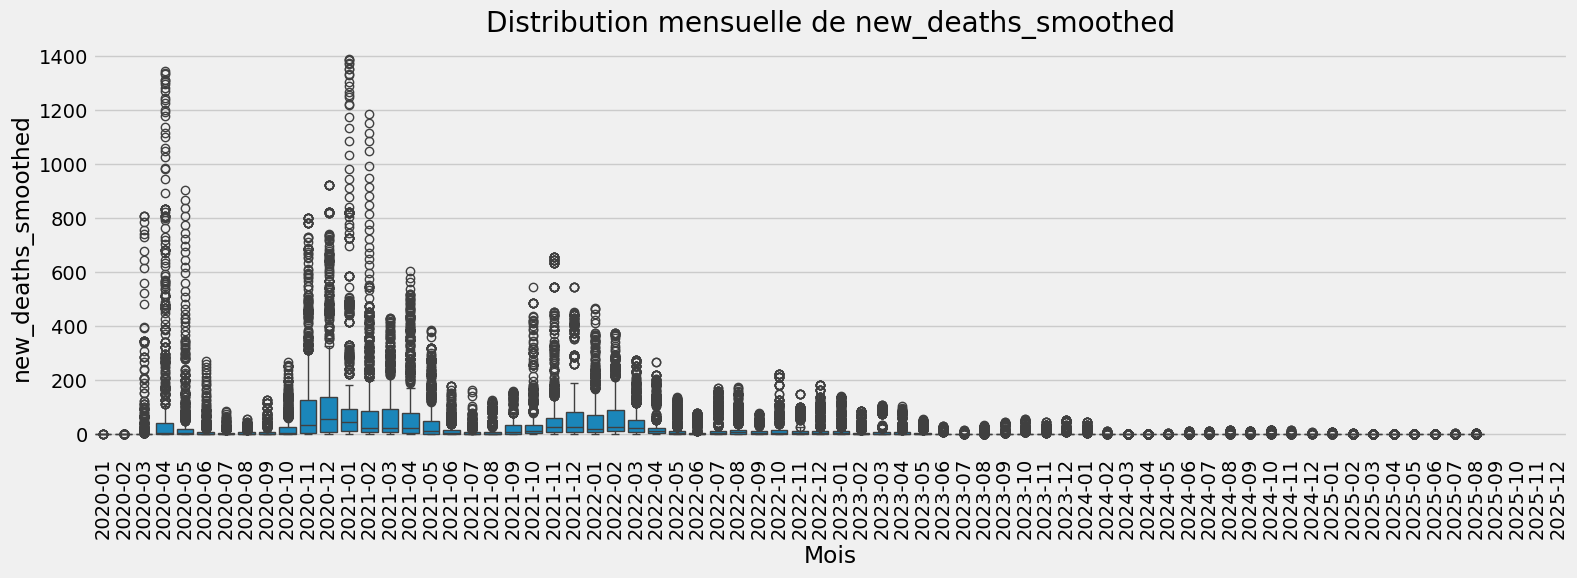

In [7]:
feature = 'new_deaths_smoothed'
df_europe['month'] = df_europe['date'].dt.to_period('M').astype(str)

plt.figure(figsize=(16,6))
sns.boxplot(x='month', y=feature, data=df_europe)
plt.xticks(rotation=90)
plt.title(f"Distribution mensuelle de {feature}")
plt.xlabel("Mois")
plt.ylabel(feature)
plt.tight_layout()
plt.show()

In [8]:
# Filtrer entre 01/02/2020 et fin 2022
df_europe = df_europe[(df_europe["date"] >= "2020-02-01") & (df_europe["date"] <= "2022-12-31")]

# Colonnes d’intérêt
features = [
    "new_deaths_smoothed", "new_cases_smoothed", "hosp_patients", "icu_patients",
    "stringency_index", "reproduction_rate", "new_tests_smoothed",
    "people_vaccinated", "people_fully_vaccinated", "total_boosters",
    "population_density", "population", "median_age", "life_expectancy",
    "gdp_per_capita", "diabetes_prevalence", "hospital_beds_per_thousand", "new_deaths",
    "new_cases", "total_cases", "total_deaths", "total_tests", "total_vaccinations", "new_tests", "new_vaccinations"
]

df_europe = df_europe[["country", "date"] + features]

### Imputation des NaN

In [9]:
nan_ratio = df_europe.isna().mean().sort_values(ascending=False)
print(nan_ratio)

total_boosters                0.693307
new_vaccinations              0.645929
people_fully_vaccinated       0.635439
people_vaccinated             0.618243
total_vaccinations            0.599142
icu_patients                  0.517264
hosp_patients                 0.438954
new_tests                     0.398444
total_tests                   0.384279
new_tests_smoothed            0.280563
reproduction_rate             0.040107
stringency_index              0.028571
hospital_beds_per_thousand    0.000000
total_deaths                  0.000000
total_cases                   0.000000
new_cases                     0.000000
new_deaths                    0.000000
country                       0.000000
diabetes_prevalence           0.000000
gdp_per_capita                0.000000
life_expectancy               0.000000
median_age                    0.000000
date                          0.000000
population_density            0.000000
new_cases_smoothed            0.000000
new_deaths_smoothed      

In [10]:
# 1. Vaccins et boosters
for col in ["people_vaccinated", "people_fully_vaccinated", "total_boosters"]:
    df_europe[col] = df_europe[col].fillna(0).interpolate()

# Hosp / ICU patients : interpolation + ffill/bfill + mean par pays
for col in ["hosp_patients", "icu_patients"]:
    # interpolation et propagation
    df_europe[col] = df_europe.groupby("country")[col].transform(
        lambda x: x.interpolate().fillna(method="ffill").fillna(method="bfill")
    )
    # Si il reste encore des NaN (tous les jours NaN pour ce pays), remplacer par moyenne globale
    df_europe[col] = df_europe[col].fillna(df_europe[col].mean())

# Autres variables temporelles : interpolation + ffill/bfill + mean par pays
for col in ["new_tests_smoothed", "reproduction_rate", "stringency_index", "total_vaccinations", "total_tests", "new_tests", "new_vaccinations"]:
    # interpolation et propagation
    df_europe[col] = df_europe.groupby("country")[col].transform(
        lambda x: x.interpolate().fillna(method="ffill").fillna(method="bfill")
    )
    # Si il reste encore des NaN (pays sans données du tout), remplacer par moyenne globale
    df_europe[col] = df_europe[col].fillna(df_europe[col].mean())



In [11]:
df_europe.isna().sum()

country                       0
date                          0
new_deaths_smoothed           0
new_cases_smoothed            0
hosp_patients                 0
icu_patients                  0
stringency_index              0
reproduction_rate             0
new_tests_smoothed            0
people_vaccinated             0
people_fully_vaccinated       0
total_boosters                0
population_density            0
population                    0
median_age                    0
life_expectancy               0
gdp_per_capita                0
diabetes_prevalence           0
hospital_beds_per_thousand    0
new_deaths                    0
new_cases                     0
total_cases                   0
total_deaths                  0
total_tests                   0
total_vaccinations            0
new_tests                     0
new_vaccinations              0
dtype: int64

## Pour la France

In [12]:
# 1. Filtrer la France
df_france = df_europe[df_europe['country'] == 'France'].copy()
df_france['date'] = pd.to_datetime(df_france['date'])
df_france = df_france.set_index('date')

# 2. Définir les colonnes par type
cols_sum = ["new_cases", "new_deaths", "new_tests", "new_vaccinations"]
cols_mean = ["hosp_patients", "icu_patients", "stringency_index", "reproduction_rate",]
cols_last = ["total_cases", "total_tests", "total_vaccinations",
             "people_vaccinated", "total_boosters"]

# 3. Calculer les agrégations
weekly_sum = df_france[cols_sum].resample("W-SUN").sum()
weekly_mean = df_france[cols_mean].resample("W-SUN").mean()
weekly_last = df_france[cols_last].resample("W-SUN").last()

# 4. Combiner tout
df_weekly_france = pd.concat([weekly_sum, weekly_mean, weekly_last], axis=1)
df_weekly_france = df_weekly_france.iloc[:-1, :]
df_weekly_france = df_weekly_france.loc["2020-09":"2022-12"]


# Résultat : un DataFrame hebdomadaire, indexé par les dimanches
print(df_weekly_france.head())


            new_cases  new_deaths  new_tests  new_vaccinations  hosp_patients  \
date                                                                            
2020-09-06    50197.0       126.0  1153183.0            4977.0    4629.428571   
2020-09-13    61432.0       258.0  1365371.0            4977.0    5061.857143   
2020-09-20    73481.0       429.0  1401487.0            4977.0    5630.428571   
2020-09-27    72509.0       559.0  1185597.0            4977.0    5971.142857   
2020-10-04    74819.0       561.0  1113751.0            4977.0    6647.000000   

            icu_patients  stringency_index  reproduction_rate  total_cases  \
date                                                                         
2020-09-06    448.857143         48.015714           1.327271     180767.0   
2020-09-13    606.428571         48.610000           1.256357     242199.0   
2020-09-20    789.571429         48.610000           1.221043     315680.0   
2020-09-27   1028.714286         47.818571

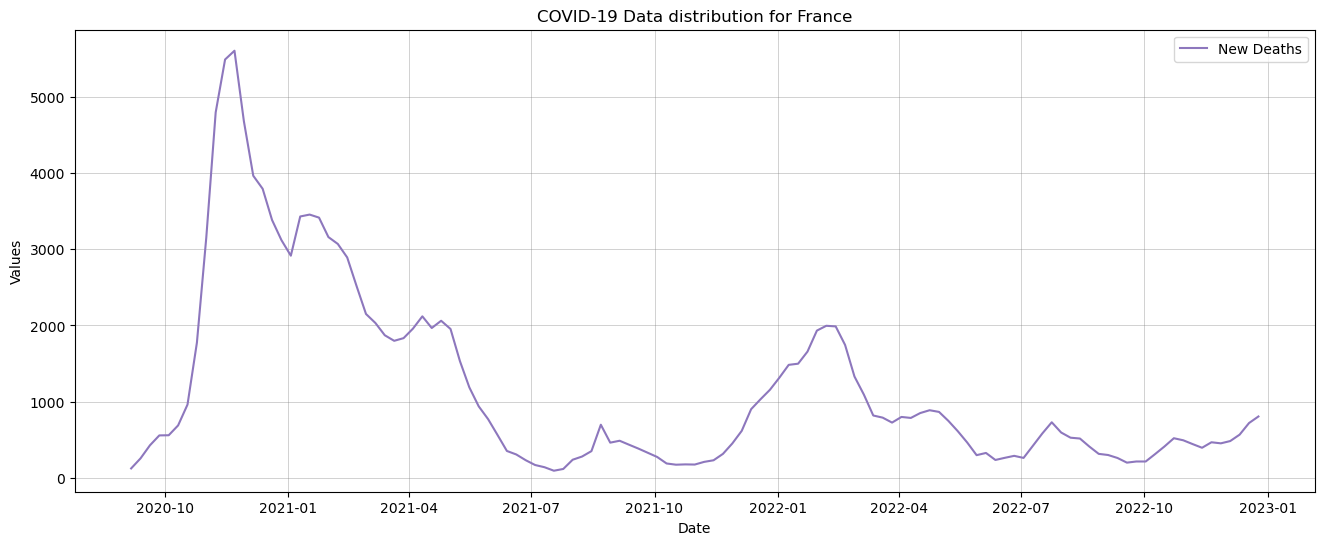

In [13]:
#plot data france
plt.style.use('default') 
plt.figure(figsize=(16,6), facecolor="white")
plt.plot(df_weekly_france.index, df_weekly_france['new_deaths'], label='New Deaths', color='#8D77BD')
ax = plt.gca()
ax.grid(True, linestyle='-', linewidth=0.5, color='gray', alpha=0.5)
ax.set_xlabel('Date')
ax.set_ylabel('Values')
ax.set_title('COVID-19 Data distribution for France')
ax.legend()

In [14]:
# Créer des lags et un horizon de forecast

def feature_engineering(df):
    # Créer des lags pour la target
    df["lag_1"] = df["new_deaths"].shift(1)
    df["lag_2"] = df["new_deaths"].shift(2)
    df["lag_3"] = df["new_deaths"].shift(3)
    df["lag_7"] = df["new_deaths"].shift(7)
    df["lag_14"] = df["new_deaths"].shift(14)

    # Moyennes et écarts-types roulants
    df["rolling_mean_3"] = df["new_deaths"].rolling(window=3).mean()
    df["rolling_std_3"] = df["new_deaths"].rolling(window=3).std()
    df["rolling_mean_7"] = df["new_deaths"].rolling(window=7).mean()
    df["rolling_std_7"] = df["new_deaths"].rolling(window=7).std()

    # Variables temporelles
    df["day_of_week"] = df.index.dayofweek
    df["months"] = df.index.month

    # Horizon de forecast (1 jour dans le futur)
    df["target_t_plus"] = df["new_deaths"].shift(-1)
    df["date_t_plus"] = df.index.shift(-1)

    return df

df_france_augmented = feature_engineering(df_weekly_france)

# Supprimer les premier lignes qui ont des NaN dues à la création des lags
df_model = df_france_augmented.dropna()

X = df_model.drop(columns=["date_t_plus","target_t_plus", "new_deaths"])
y = df_model[["date_t_plus", "target_t_plus"]]


In [15]:
train_size = int(len(X) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

In [19]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    """
    Evaluate a regression model using time series cross-validation, and report performance on a test set.
    
    Parameters:
    - model: sklearn-like estimator
    - X_train, X_test: pd.DataFrame, features
    - y_train, y_test: pd.DataFrame, target (must contain 'target_t_plus' and optionally 'date_t_plus')
    """
    model_name = model.__class__.__name__

    # Cross-validation on training data
    tscv = TimeSeriesSplit(n_splits=3)
    scores = cross_val_score(
        model, X_train, y_train['target_t_plus'],
        cv=tscv, scoring='neg_root_mean_squared_error'
    )

    rmse_scores = -scores
    print(f"{model_name} - RMSE for each split: {rmse_scores}")
    print(f"{model_name} - Mean RMSE: {rmse_scores.mean():.4f}")

    # Fit model and predict on test set
    model.fit(X_train, y_train['target_t_plus'])
    y_pred = model.predict(X_test)

    # Evaluation on test set
    rmse_test = root_mean_squared_error(y_test['target_t_plus'], y_pred)
    print(f"{model_name} Test Set -> RMSE: {rmse_test:.4f}")

    # Plot predictions vs actual
    plt.figure(figsize=(14, 7), facecolor="white")
    plt.plot(y_test['date_t_plus'], y_test['target_t_plus'], label='Actual', color='#8D77BD')
    plt.plot(y_test['date_t_plus'], y_pred, label='Predicted', color="#B93B6D")
    plt.xlabel('Date')
    plt.ylabel('New Deaths')
    plt.title(f'{model_name} - Next-Day Prediction of COVID Deaths (France)')
    plt.grid(True, linestyle='-', linewidth=0.5, color='gray', alpha=0.5)
    plt.legend()
    plt.show()

    # Feature importances (if available)
    if hasattr(model, "feature_importances_"):
        feature_importances = model.feature_importances_
        coef_df = pd.DataFrame({
            "Feature": X_train.columns,
            "Importance": feature_importances
        }).sort_values(by="Importance", ascending=True)

        fig, ax = plt.subplots(figsize=(10, 8))
        ax.barh(coef_df["Feature"], coef_df["Importance"], color="#B93BAC")
        ax.set_xlabel("Importance")
        ax.set_title(f"{model_name} - Feature Importance for Predicting COVID Deaths")
        ax.grid(True, linestyle='-', linewidth=0.5, color='gray', alpha=0.5)

        # Add values to bars
        for i, (imp, feat) in enumerate(zip(coef_df["Importance"], coef_df["Feature"])):
            ax.text(imp + 0.001, i, f"{imp:.3f}", va="center")

        plt.tight_layout()
        plt.show()

RandomForestRegressor - RMSE for each split: [1606.14886165  711.92871255  522.39352657]
RandomForestRegressor - Mean RMSE: 946.8237
RandomForestRegressor Test Set -> RMSE: 106.1792


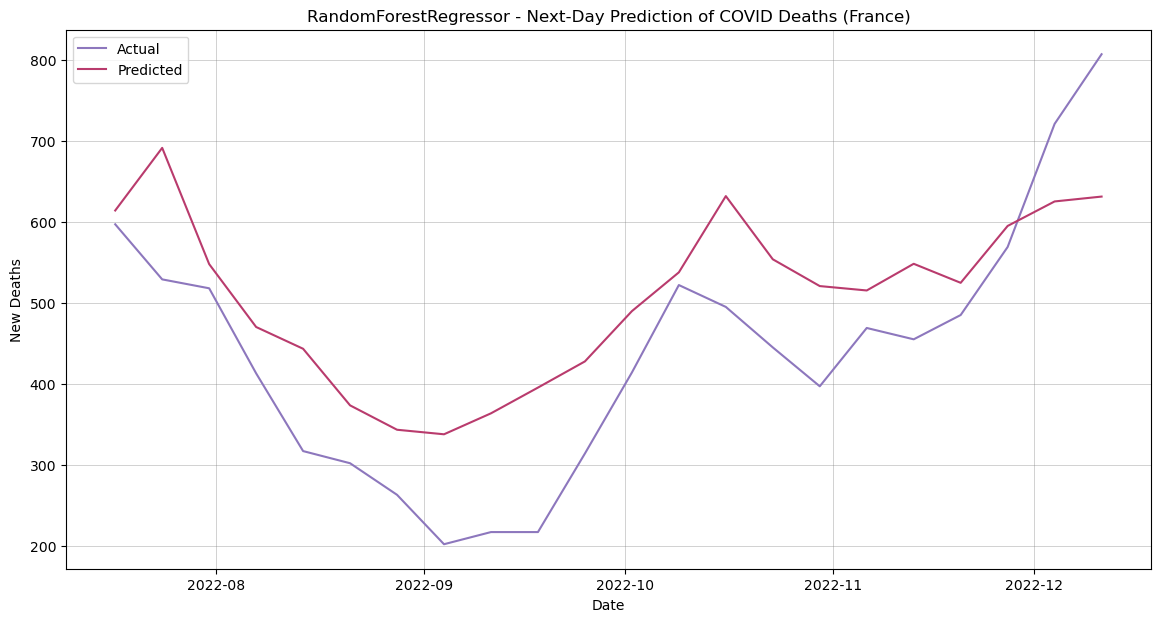

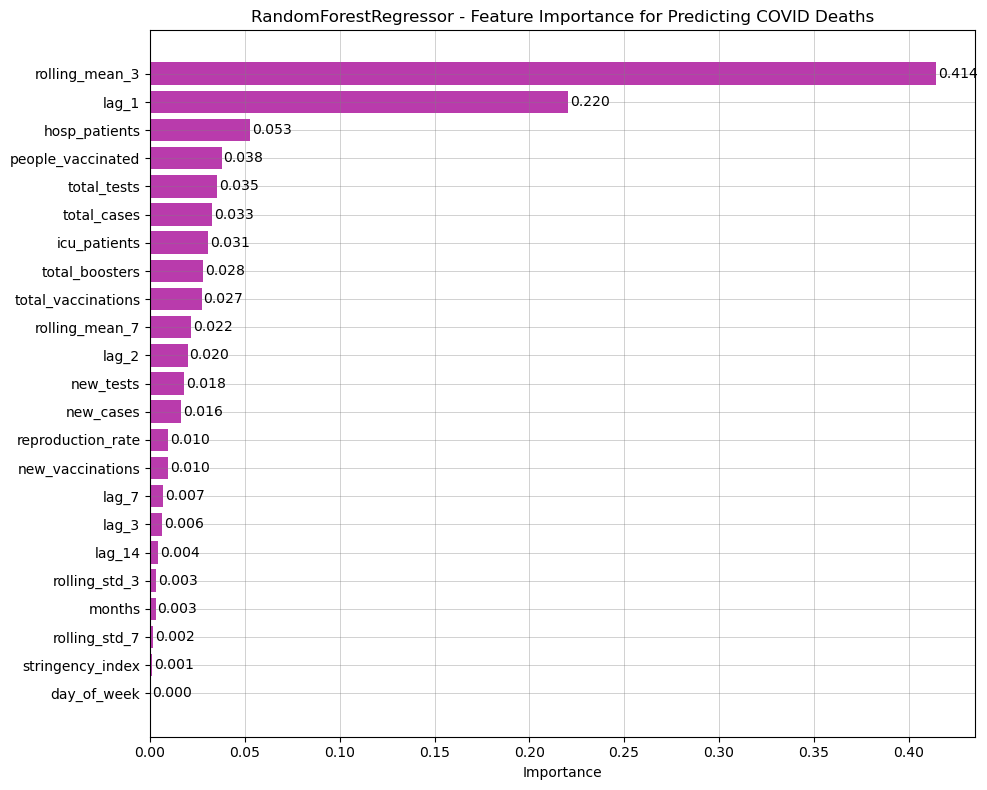

In [20]:
evaluate_model(RandomForestRegressor(random_state=42), X_train, y_train, X_test, y_test)

## avec que les lags

RandomForestRegressor - RMSE for each split: [1535.14173866  650.27265023  282.18226818]
RandomForestRegressor - Mean RMSE: 822.5322
RandomForestRegressor Test Set -> RMSE: 116.5661


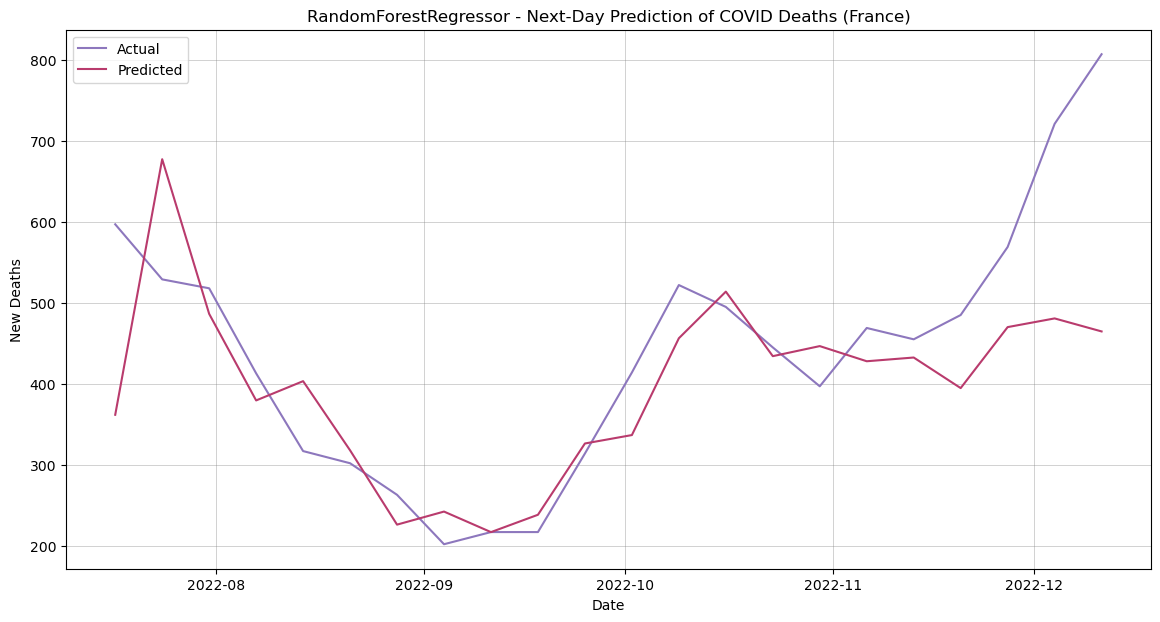

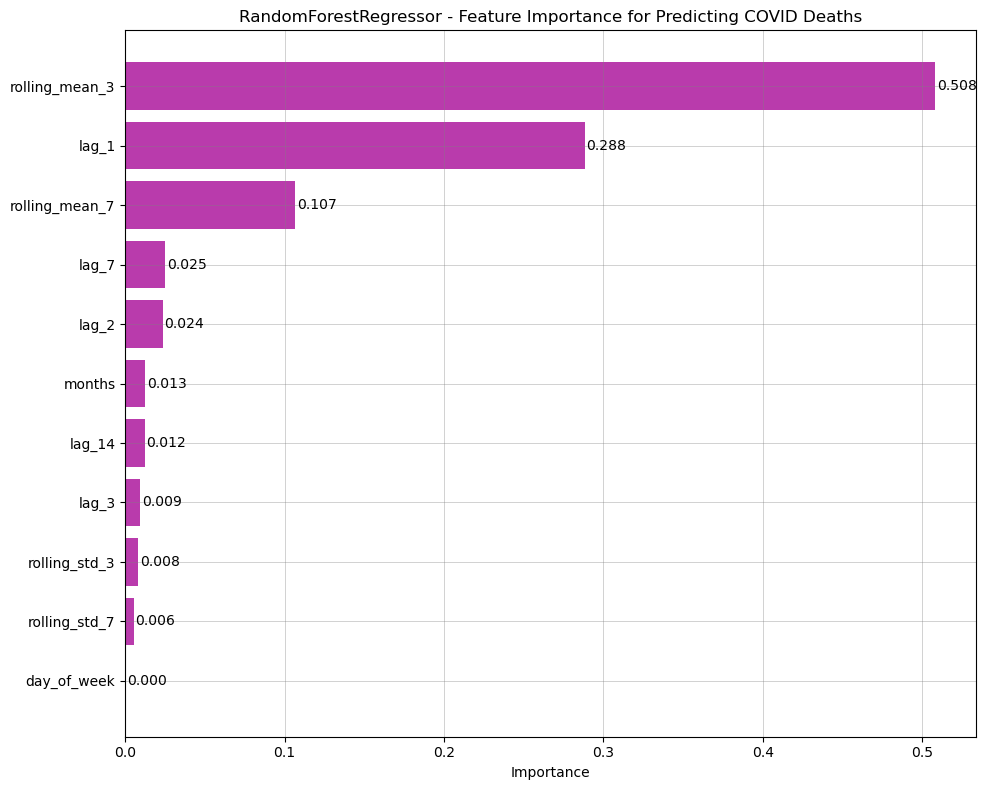

In [21]:
X_lags = X[["lag_1", "lag_2", "lag_3", "lag_7", "lag_14", "rolling_mean_3", "rolling_std_3", "rolling_mean_7", "rolling_std_7", "day_of_week", "months"]]
evaluate_model(RandomForestRegressor(random_state=42), X_lags.iloc[:train_size], y_train, X_lags.iloc[train_size:], y_test)

## XGBoost

XGBRegressor - RMSE for each split: [1676.8400683   455.21547334  971.35568374]
XGBRegressor - Mean RMSE: 1034.4704
XGBRegressor Test Set -> RMSE: 221.5520


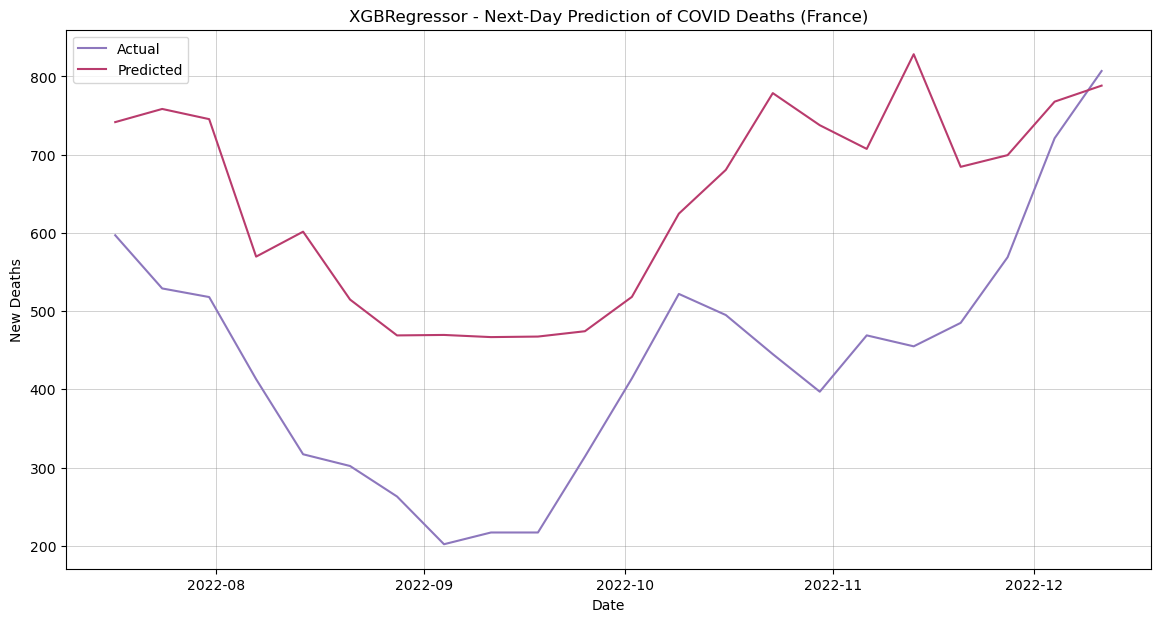

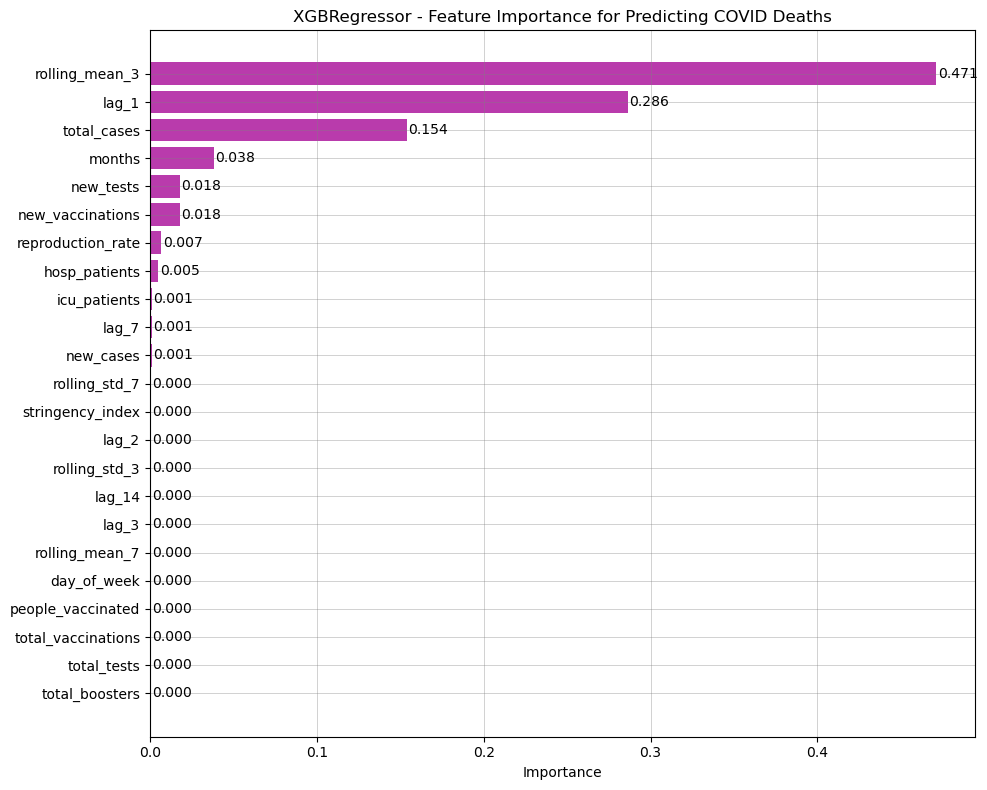

In [22]:
evaluate_model(xgb.XGBRegressor(random_state=42), X_train, y_train, X_test, y_test)

XGBRegressor - RMSE for each split: [1471.02359533  599.54924458  353.1741181 ]
XGBRegressor - Mean RMSE: 807.9157
XGBRegressor Test Set -> RMSE: 94.4661


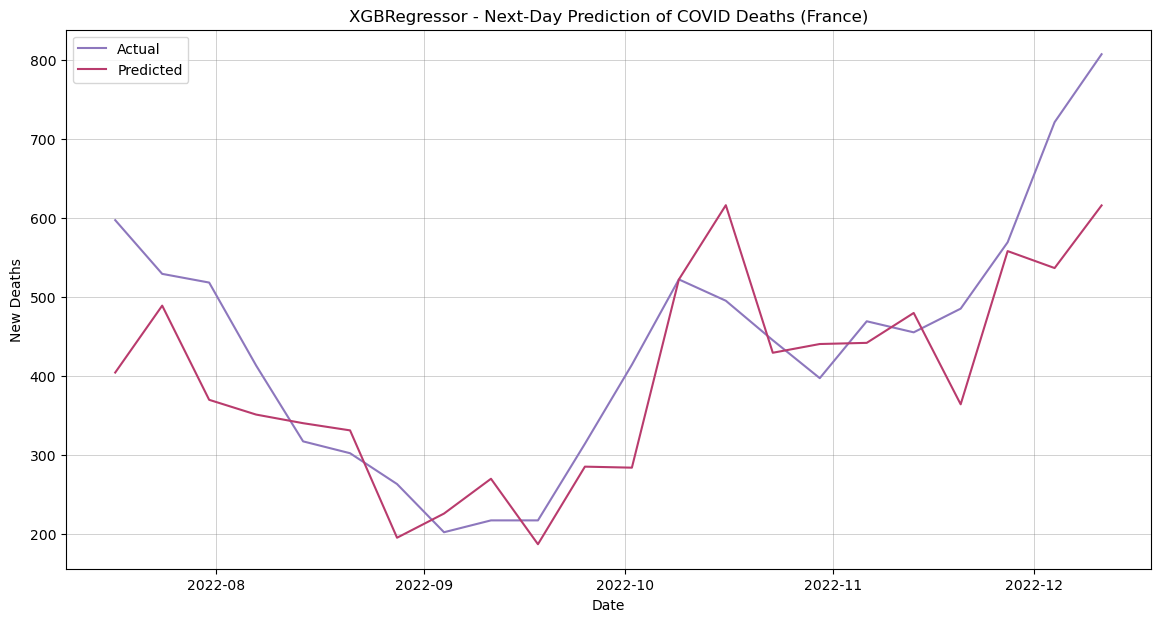

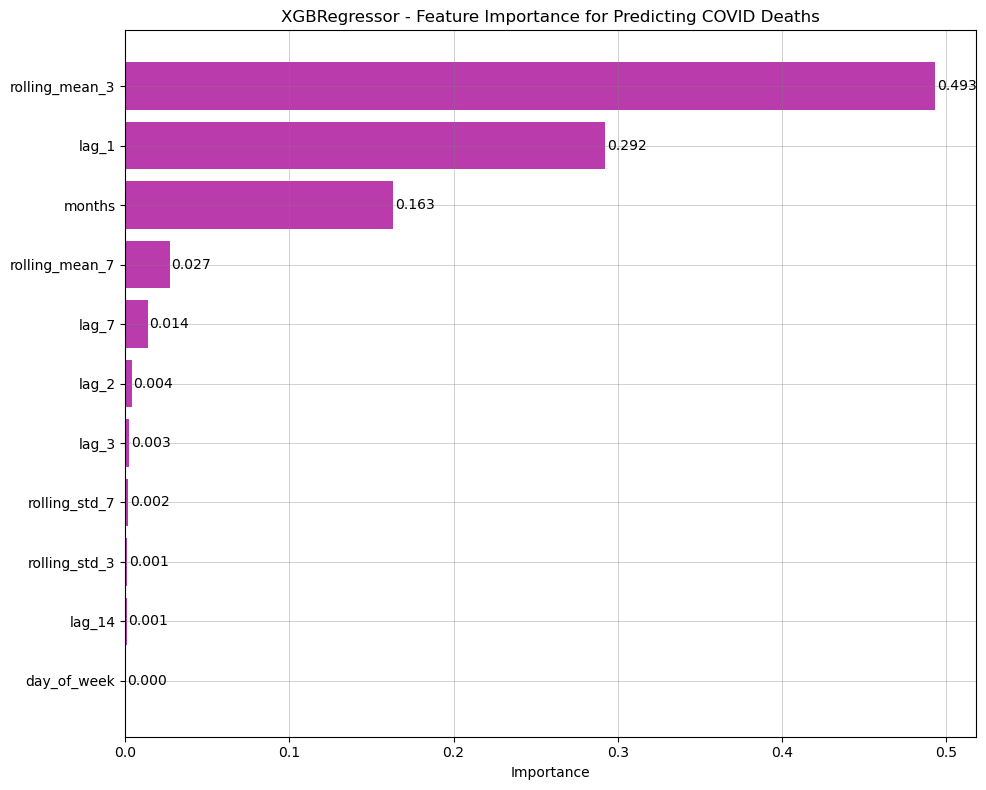

In [23]:
evaluate_model(xgb.XGBRegressor(random_state=42), X_lags.iloc[:train_size], y_train, X_lags.iloc[train_size:], y_test)

## HPO (hyperparameters optimization) with Optuna

### RF

In [ ]:
import optuna

### HPO (hyperparameters optimization) with Optuna
def objective(trial):
    # Hyperparameters to tune
    n_estimators = trial.suggest_int('n_estimators', 100, 1000)
    max_depth = trial.suggest_int('max_depth', 5, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)

    # Create the model with the suggested hyperparameters
    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )

    # Cross-validation
    scores = cross_val_score(model, X, y['target_t_plus'], cv=tscv, scoring='neg_root_mean_squared_error')
    
    # Return the mean RMSE across the folds
    ponderation = np.array([0.2,0.3,0.5])
    return -scores.dot(ponderation) #dot : produit entre vecteurs
# ponderation des features

study = optuna.create_study()
study.optimize(objective, n_trials=100)

print("Best trial:")
trial = study.best_trial
print(f"  Value: {trial.value}")
print(trial.params)


[I 2025-09-30 23:56:11,515] A new study created in memory with name: no-name-de838b14-59e9-4be5-9e3a-f8924606c31d
[I 2025-09-30 23:56:13,703] Trial 0 finished with value: 560.9741768374097 and parameters: {'n_estimators': 575, 'max_depth': 40, 'min_samples_split': 7, 'min_samples_leaf': 13}. Best is trial 0 with value: 560.9741768374097.
[I 2025-09-30 23:56:16,938] Trial 1 finished with value: 505.8065651217436 and parameters: {'n_estimators': 744, 'max_depth': 37, 'min_samples_split': 16, 'min_samples_leaf': 15}. Best is trial 1 with value: 505.8065651217436.
[I 2025-09-30 23:56:19,171] Trial 2 finished with value: 483.07178980261926 and parameters: {'n_estimators': 512, 'max_depth': 10, 'min_samples_split': 13, 'min_samples_leaf': 9}. Best is trial 2 with value: 483.07178980261926.
[I 2025-09-30 23:56:20,638] Trial 3 finished with value: 563.1702422343778 and parameters: {'n_estimators': 450, 'max_depth': 28, 'min_samples_split': 12, 'min_samples_leaf': 18}. Best is trial 2 with valu

Best trial:
  Value: 252.3460856173241
{'n_estimators': 305, 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 1}


In [ ]:
tscv = TimeSeriesSplit(n_splits=3)

param = {'n_estimators': 305, 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 1}

rf_france_model = RandomForestRegressor(
    n_estimators=param['n_estimators'],
    max_depth=param['max_depth'],
    min_samples_split=param['min_samples_split'],
    min_samples_leaf=param['min_samples_leaf'],
    random_state=42
)
rf_scores = cross_val_score(rf_france_model, X, y['target_t_plus'], cv=tscv, scoring='neg_root_mean_squared_error')
print("Random Forest - RMSE pour chaque split :", -rf_scores)
print("Random Forest - RMSE moyen :", -rf_scores.mean())

rf_france_model.fit(X_train, y_train['target_t_plus'])
y_pred_france = rf_france_model.predict(X_test)

# Évaluation
mse_france = root_mean_squared_error(y_test['target_t_plus'], y_pred_france)
r2_france = r2_score(y_test['target_t_plus'], y_pred_france)
print(f"Random Forest France -> RMSE: {mse_france:.4f}, R2: {r2_france:.4f}")

Random Forest - RMSE pour chaque split : [339.08334222 448.7696457   99.79704693]
Random Forest - RMSE moyen : 295.8833449494378
Random Forest France -> RMSE: 109.9048, R2: 0.4914


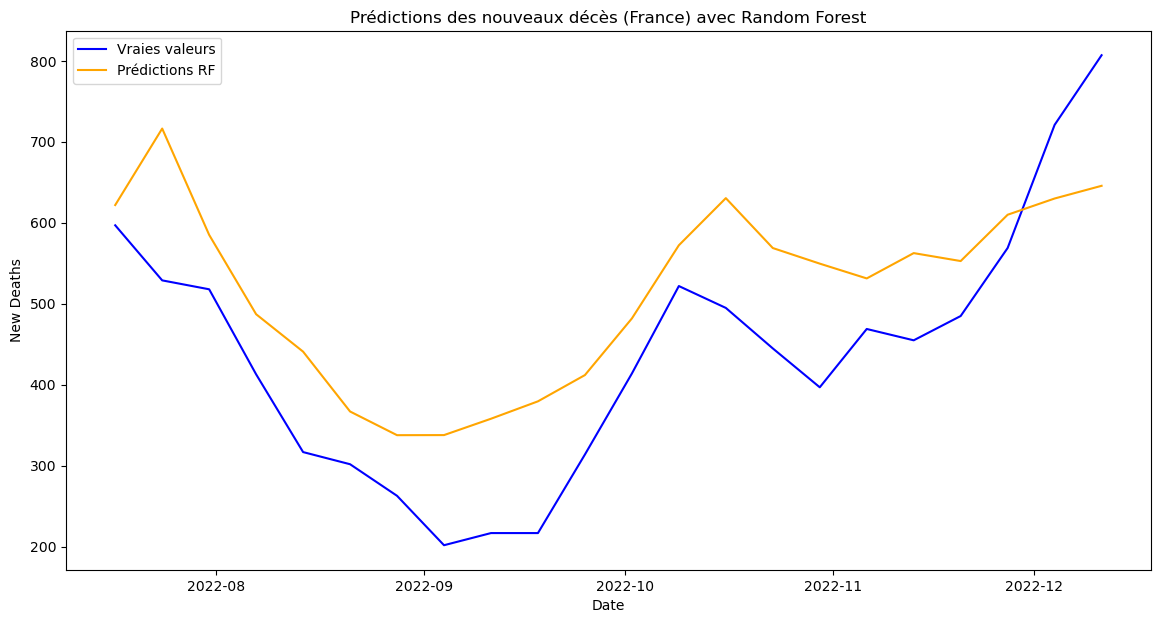

In [ ]:
# plot des résultats
plt.figure(figsize=(14,7))
plt.plot(y_test['date_t_plus'], y_test['target_t_plus'], label='Vraies valeurs', color='blue')
plt.plot(y_test['date_t_plus'], y_pred_france, label='Prédictions RF', color='orange')
plt.xlabel('Date')
plt.ylabel('New Deaths')
plt.title('Prédictions des nouveaux décès (France) avec Random Forest')
plt.legend()
plt.show()

### XGBoost

In [ ]:
import optuna

tscv = TimeSeriesSplit(n_splits=3)

def objective(trial):
    # Hyperparameters to tune (valid for XGBRegressor)
    n_estimators = trial.suggest_int('n_estimators', 100, 1000)
    max_depth = trial.suggest_int('max_depth', 3, 12)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3, log=True)
    subsample = trial.suggest_float('subsample', 0.5, 1.0)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0)
    gamma = trial.suggest_float('gamma', 0, 5)

    # Create the model
    model = xgb.XGBRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        gamma=gamma,
        random_state=42,
        objective='reg:squarederror',
        n_jobs=-1
    )

    # Cross-validation
    scores = cross_val_score(
        model,
        X,
        y['target_t_plus'],
        cv=tscv,
        scoring='neg_root_mean_squared_error'
    )
    ponderation = np.array([0.2,0.3,0.5])
    return -scores.dot(ponderation) #dot : produit entre vecteurs
    #return -scores.mean()

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)

print("Best trial:")
trial = study.best_trial
print(f"  Value: {trial.value}")
print("  Params: ")
print(trial.params)


[I 2025-10-01 00:10:54,461] A new study created in memory with name: no-name-f26a4fe7-412f-49a8-a1f3-e748585d389d
[I 2025-10-01 00:10:57,069] Trial 0 finished with value: 394.62847530601283 and parameters: {'n_estimators': 295, 'max_depth': 3, 'learning_rate': 0.11756224968491913, 'subsample': 0.9084820090729058, 'colsample_bytree': 0.7920403008253822, 'gamma': 4.256700060591291}. Best is trial 0 with value: 394.62847530601283.
[I 2025-10-01 00:11:01,814] Trial 1 finished with value: 423.13400173543835 and parameters: {'n_estimators': 506, 'max_depth': 5, 'learning_rate': 0.16954745352255482, 'subsample': 0.7451407020807598, 'colsample_bytree': 0.8007275515312491, 'gamma': 0.7597923323855427}. Best is trial 0 with value: 394.62847530601283.
[I 2025-10-01 00:11:03,085] Trial 2 finished with value: 493.1971804244494 and parameters: {'n_estimators': 123, 'max_depth': 4, 'learning_rate': 0.010781251496460023, 'subsample': 0.7237947999388665, 'colsample_bytree': 0.5431859630614684, 'gamma':

Best trial:
  Value: 288.90772396297666
  Params: 
{'n_estimators': 290, 'max_depth': 5, 'learning_rate': 0.13662250155407524, 'subsample': 0.52936190243025, 'colsample_bytree': 0.5187429609948483, 'gamma': 1.197743897232566}


In [ ]:
param = {'n_estimators': 290, 'max_depth': 5, 'learning_rate': 0.13662250155407524, 'subsample': 0.52936190243025, 'colsample_bytree': 0.5187429609948483, 'gamma': 1.197743897232566}

xgb_france_model = xgb.XGBRegressor(
    n_estimators=param['n_estimators'],
    max_depth=param['max_depth'],
    learning_rate=param['learning_rate'],
    subsample=param['subsample'],
    colsample_bytree=param['colsample_bytree'],
    gamma=param['gamma'],
    random_state=42,
    objective='reg:squarederror',
    n_jobs=-1
)

xgb_france_model.fit(X_train, y_train['target_t_plus'])
y_pred_france = xgb_france_model.predict(X_test)

# Évaluation
mse_france = root_mean_squared_error(y_test['target_t_plus'], y_pred_france)
r2_france = r2_score(y_test['target_t_plus'], y_pred_france)
print(f"XGBoost France -> RMSE: {mse_france:.4f}, R2: {r2_france:.4f}")

XGBoost France -> RMSE: 167.6571, R2: -0.1834


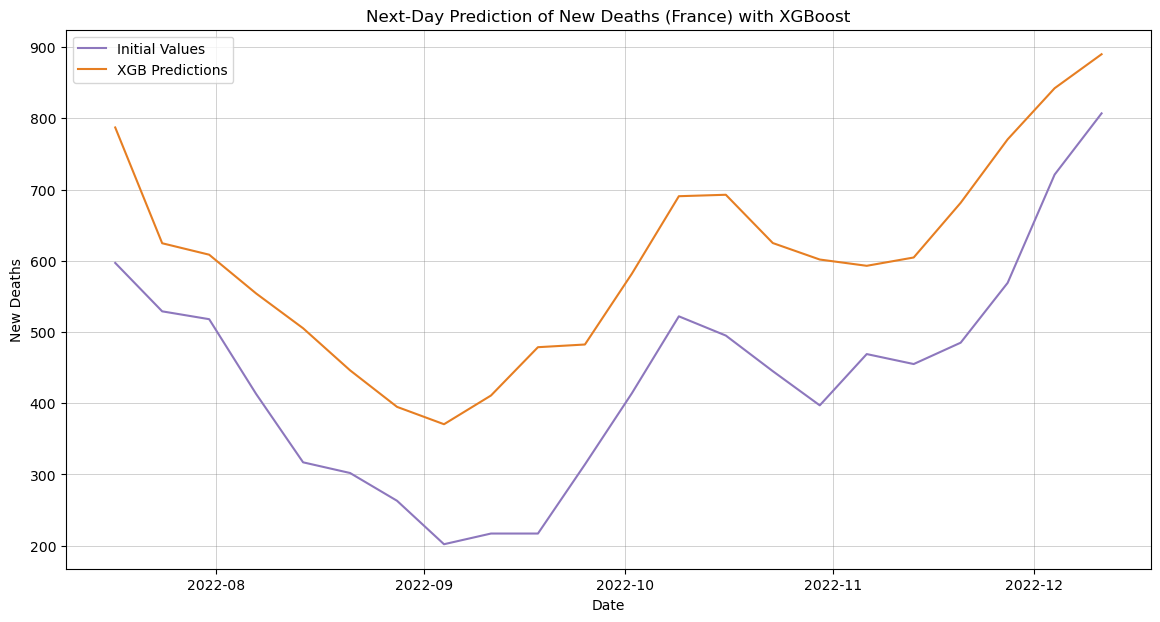

In [ ]:
# plot des résultats
plt.figure(figsize=(14,7), facecolor="white")
plt.plot(y_test['date_t_plus'], y_test['target_t_plus'], label='Initial Values', color='#8D77BD')
plt.plot(y_test['date_t_plus'], y_pred_france, label='XGB Predictions', color="#E67E22")
ax = plt.gca()
ax.set_xlabel('Date')
ax.set_ylabel('New Deaths')
ax.set_title('Next-Day Prediction of New Deaths (France) with XGBoost')
ax.grid(True, linestyle='-', linewidth=0.5, color='gray', alpha=0.5)
ax.legend()
plt.show()

## Generalisation

In [ ]:
df_europe.country.unique()

array(['Austria', 'Belarus', 'Belgium', 'Bosnia and Herzegovina',
       'Bulgaria', 'Croatia', 'Cyprus', 'Denmark', 'Estonia', 'Finland',
       'France', 'Germany', 'Greece', 'Hungary', 'Iceland', 'Ireland',
       'Italy', 'Latvia', 'Lithuania', 'Luxembourg', 'Moldova',
       'Montenegro', 'Netherlands', 'Norway', 'Poland', 'Portugal',
       'Romania', 'Serbia', 'Slovakia', 'Slovenia', 'Spain', 'Sweden',
       'Switzerland', 'Ukraine', 'United Kingdom'], dtype=object)

In [24]:
df_italy = df_europe[df_europe['country'] == 'Italy']

In [25]:
df_italy_augmented = feature_engineering(df_italy)

# Supprimer les lignes qui ont des NaN
df_model = df_italy_augmented.dropna()

#X = df_model.drop(columns=["country", "date", "date_t_plus7","target_t_plus7", "new_deaths"])
y_italy = df_model[["date_t_plus7", "target_t_plus7"]]
X_italy = X[["lag_1", "lag_2", "lag_3", "lag_7", "lag_14", "rolling_mean_3", "rolling_std_3", "rolling_mean_7", "rolling_std_7", "day_of_week", "months"]]

AttributeError: 'Index' object has no attribute 'dayofweek'

89.03646017412028


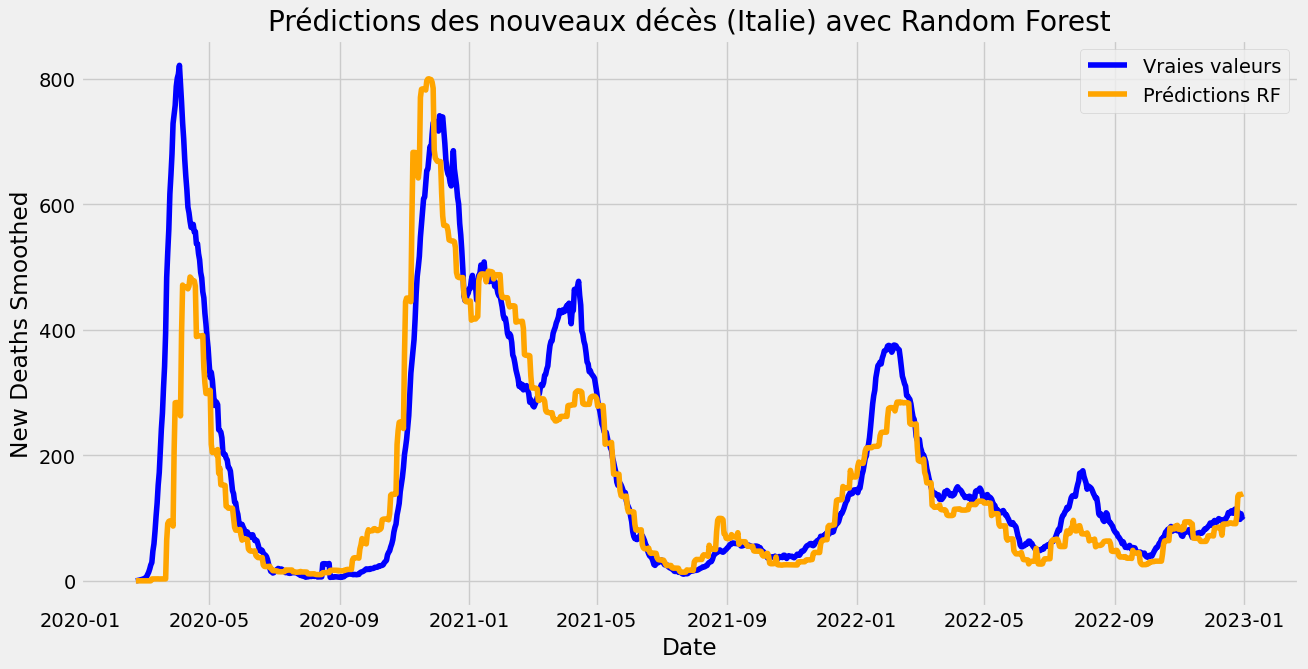

In [ ]:
y_pred_italy = rf_france_model.predict(X)

rmse_italy = root_mean_squared_error(y_italy['target_t_plus7'], y_pred_italy)
print(rmse_italy)

# plot des résultats
plt.figure(figsize=(14,7))
plt.plot(y_italy['date_t_plus7'], y_italy['target_t_plus7'], label='Vraies valeurs', color='blue')
plt.plot(y_italy['date_t_plus7'], y_pred_italy, label='Prédictions RF', color='orange')
plt.xlabel('Date')
plt.ylabel('New Deaths Smoothed')
plt.title('Prédictions des nouveaux décès (Italie) avec Random Forest')
plt.legend()
plt.show()


### Allemagne

In [ ]:
df_europe.country.unique()

array(['Austria', 'Belarus', 'Belgium', 'Bosnia and Herzegovina',
       'Bulgaria', 'Croatia', 'Cyprus', 'Denmark', 'Estonia', 'Finland',
       'France', 'Germany', 'Greece', 'Hungary', 'Iceland', 'Ireland',
       'Italy', 'Latvia', 'Lithuania', 'Luxembourg', 'Moldova',
       'Montenegro', 'Netherlands', 'Norway', 'Poland', 'Portugal',
       'Romania', 'Serbia', 'Slovakia', 'Slovenia', 'Spain', 'Sweden',
       'Switzerland', 'Ukraine', 'United Kingdom'], dtype=object)

In [ ]:
df_germany = df_europe[df_europe['country'] == 'Germany']

In [ ]:
df_germany_augmented = feature_engineering(df_germany)

# Supprimer les lignes qui ont des NaN
df_model = df_germany_augmented.dropna()

#X = df_model.drop(columns=["country", "date", "date_t_plus7","target_t_plus7", "new_deaths"])
y_germany = df_model[["date_t_plus7", "target_t_plus7"]]
X_germany = X[["lag_1", "lag_2", "lag_3", "lag_7", "lag_14", "rolling_mean_3", "rolling_std_3", "rolling_mean_7", "rolling_std_7", "day_of_week", "months"]]

In [ ]:
y_germany_pred = rf_france_model.predict(X_germany)
rmse_germany = root_mean_squared_error(y_germany['target_t_plus7'], y_germany_pred)
print(rmse_germany)

131.06758548522953


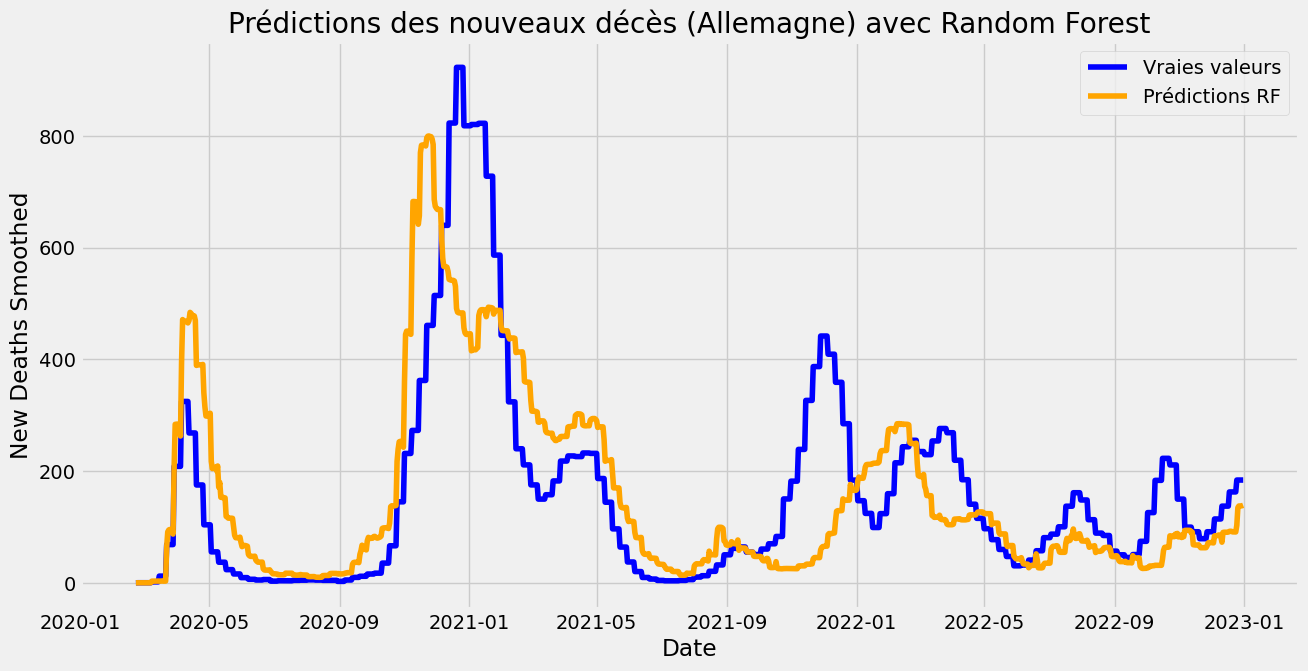

In [ ]:
# plot des résultats
plt.figure(figsize=(14,7))
plt.plot(y_germany['date_t_plus7'], y_germany['target_t_plus7'], label='Vraies valeurs', color='blue')
plt.plot(y_germany['date_t_plus7'], y_germany_pred, label='Prédictions RF', color='orange')
plt.xlabel('Date')
plt.ylabel('New Deaths Smoothed')
plt.title('Prédictions des nouveaux décès (Allemagne) avec Random Forest')
plt.legend()
plt.show()


## SARIMA car new_death_smoothed capture la saisonnalité

                                      SARIMAX Results                                      
Dep. Variable:                      target_t_plus7   No. Observations:                 1044
Model:             SARIMAX(2, 1, 2)x(1, 1, [1], 7)   Log Likelihood               -4127.362
Date:                             Sun, 28 Sep 2025   AIC                           8268.723
Time:                                     23:30:49   BIC                           8303.325
Sample:                                          0   HQIC                          8281.852
                                            - 1044                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0009    747.622   1.22e-06      1.000   -1465.311    1465.312
ar.L2          0.0009    86

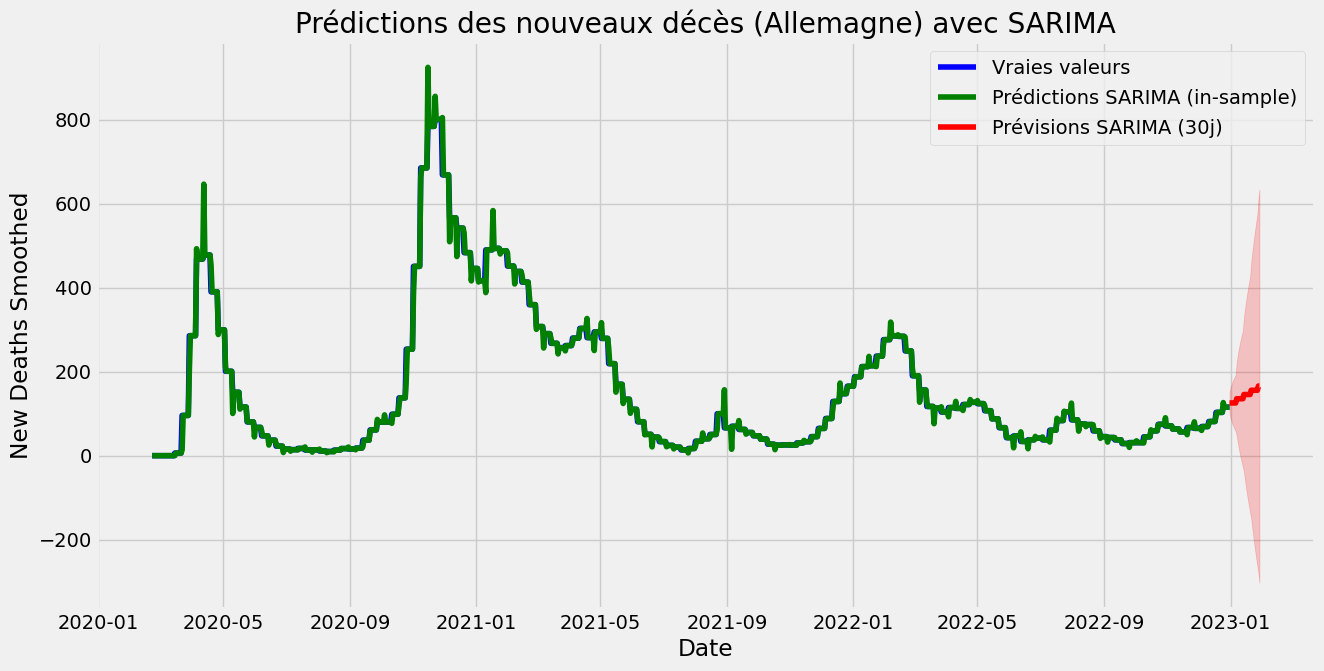

In [ ]:
dates = df_model["date_t_plus7"]
y = df_model["target_t_plus7"]

# --- Entraîner le SARIMA ---
model_sarima = SARIMAX(y, order=(2,1,2), seasonal_order=(1,1,1,7))
result = model_sarima.fit()

print(result.summary())

# --- Faire une prédiction sur toute la période disponible ---
y_pred = result.fittedvalues  # valeurs ajustées sur l'échantillon

# --- Faire une prévision sur 30 pas en avant ---
forecast = result.get_forecast(steps=30)
forecast_ci = forecast.conf_int()

# --- Plot ---
plt.figure(figsize=(14,7))
plt.plot(dates, y, label="Vraies valeurs", color="blue")
plt.plot(dates, y_pred, label="Prédictions SARIMA (in-sample)", color="green")

# Ajouter les prévisions futures
future_dates = pd.date_range(start=dates.iloc[-1], periods=30, freq="D")
plt.plot(future_dates, forecast.predicted_mean, label="Prévisions SARIMA (30j)", color="red")
plt.fill_between(future_dates,
                 forecast_ci.iloc[:,0],
                 forecast_ci.iloc[:,1],
                 color="red", alpha=0.2)

plt.xlabel("Date")
plt.ylabel("New Deaths Smoothed")
plt.title("Prédictions des nouveaux décès (Allemagne) avec SARIMA")
plt.legend()
plt.show()
